In [57]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from tabulate import tabulate
import functools

## define function for printing pandas dataframes as markdown (in case it is needed)

In [58]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [59]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## helper fuction for showing values on bars
adapted from: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

In [60]:
def show_values_on_bars(axs, h_v="v", horizontal_space=5, vertical_space=5, ha="center", va="bottom", fontsize=12):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(vertical_space)
                # print(p.get_height())
                value = int(p.get_height())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(horizontal_space)
                # print(p.get_width())
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## load saved data

In [61]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

In [62]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

# Plot data

## plot get patient counts by gender

In [199]:
gender_count = pds.DataFrame(patient_df.gender.value_counts())
# gender_count = patient_df.gender.value_counts()
gender_count.loc['total'] = len(patient_df)
gender_count['percent'] = (gender_count['gender']/len(patient_df)) * 100
gender_count['percent'] = round(gender_count['percent'], 1)
gender_count.columns = ['total', 'percent']
gender_count

,total,percent
female,121855,56.2
male,95047,43.8
total,216902,100.0


In [200]:
# print_pandas_md(pds.DataFrame(gender_count)) # in case I need the table in markdown

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/331486333.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


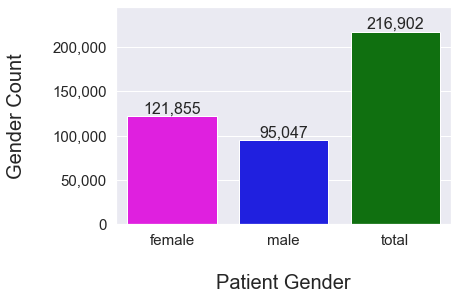

In [201]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue', 'green']
sns.set_palette(colors)

# plot gender counts
ax = sns.barplot(x=gender_count.index, y=gender_count['total'])
ax.set_xlabel("\nPatient Gender", size=20)
ax.set_ylabel("Gender Count\n", size=20)
plt.xticks(size=15)
plt.yticks(size=15)

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=16)

## add extra room at top of figure
ax.set_ylim(0, 245000)

plt.savefig("figures/patient-gender-counts.png", dpi=600, bbox_inches="tight")
plt.show()

## calculate age distributions and plot

### determine age intervals (i.e., bins)

find min max ages

In [139]:
print('min:', patient_df['patient_age'].min())
print('max:', patient_df['patient_age'].max())

min: 1
max: 112


use min/max to define bins for histogram  
**note**: add 1 to max to capture last age value

In [241]:
age_bins = np.linspace(0, 113, 10)
age_bins = np.around(age_bins, decimals=0)
age_bins

array([  0.,  13.,  25.,  38.,  50.,  63.,  75.,  88., 100., 113.])

### use age bins to create:
* age_table
* female_age_table
* male_age_table  

when finished merge all tables to single table

In [301]:
# determine age range counts
# NB: use right=False in cut to make counts match the histogram
age_table = \
    pds.DataFrame(pds.cut(patient_df['patient_age'], age_bins, right=False)\
                  .value_counts().sort_index()).reset_index()
age_table.rename(columns={'index': 'age_range', 'patient_age': 'total'}, inplace=True)
age_table

,age_range,total
0,"[0.0, 13.0)",4351
1,"[13.0, 25.0)",33787
2,"[25.0, 38.0)",50820
3,"[38.0, 50.0)",44080
4,"[50.0, 63.0)",44480
5,"[63.0, 75.0)",26246
6,"[75.0, 88.0)",10808
7,"[88.0, 100.0)",2190
8,"[100.0, 113.0)",140


In [267]:
# determine female age range counts
# NB: use right=False in cut to make counts match the histogram
females = patient_df.query("gender == 'female'")['patient_age']
female_age_table = \
    pds.DataFrame(pds.cut(females, age_bins, right=False)\
                  .value_counts().sort_index()).reset_index()
female_age_table.rename(columns={'index': 'age_range', 'patient_age': 'female_total'}, inplace=True)
female_age_table

,age_range,female_total
0,"[0.0, 13.0)",2348
1,"[13.0, 25.0)",17880
2,"[25.0, 38.0)",29622
3,"[38.0, 50.0)",25424
4,"[50.0, 63.0)",25086
5,"[63.0, 75.0)",14273
6,"[75.0, 88.0)",5818
7,"[88.0, 100.0)",1307
8,"[100.0, 113.0)",97


In [268]:
# determine male age range counts
# NB: use right=False in cut to make counts match the histogram
males = patient_df.query("gender == 'male'")['patient_age']
male_age_table = \
    pds.DataFrame(pds.cut(males, age_bins, right=False)\
                  .value_counts().sort_index()).reset_index()
male_age_table.rename(columns={'index': 'age_range', 'patient_age': 'male_total'}, inplace=True)
male_age_table

,age_range,male_total
0,"[0.0, 13.0)",2003
1,"[13.0, 25.0)",15907
2,"[25.0, 38.0)",21198
3,"[38.0, 50.0)",18656
4,"[50.0, 63.0)",19394
5,"[63.0, 75.0)",11973
6,"[75.0, 88.0)",4990
7,"[88.0, 100.0)",883
8,"[100.0, 113.0)",43


### merge into a single age table

In [302]:
age_table = pds.merge(pds.merge(age_table, female_age_table), male_age_table)
age_table

,age_range,total,female_total,male_total
0,"[0.0, 13.0)",4351,2348,2003
1,"[13.0, 25.0)",33787,17880,15907
2,"[25.0, 38.0)",50820,29622,21198
3,"[38.0, 50.0)",44080,25424,18656
4,"[50.0, 63.0)",44480,25086,19394
5,"[63.0, 75.0)",26246,14273,11973
6,"[75.0, 88.0)",10808,5818,4990
7,"[88.0, 100.0)",2190,1307,883
8,"[100.0, 113.0)",140,97,43


### calculate percentages

In [303]:
age_table['percent'] = round((age_table['total'] / len(patient_df)) * 100, 1)
age_table['percent_female'] = round((age_table['female_total'] / age_table['total']) * 100, 1)
age_table['percent_male'] = round((age_table['male_total'] / age_table['total']) * 100, 1)
age_table

,age_range,total,female_total,male_total,percent,percent_female,percent_male
0,"[0.0, 13.0)",4351,2348,2003,2.0,54.0,46.0
1,"[13.0, 25.0)",33787,17880,15907,15.6,52.9,47.1
2,"[25.0, 38.0)",50820,29622,21198,23.4,58.3,41.7
3,"[38.0, 50.0)",44080,25424,18656,20.3,57.7,42.3
4,"[50.0, 63.0)",44480,25086,19394,20.5,56.4,43.6
5,"[63.0, 75.0)",26246,14273,11973,12.1,54.4,45.6
6,"[75.0, 88.0)",10808,5818,4990,5.0,53.8,46.2
7,"[88.0, 100.0)",2190,1307,883,1.0,59.7,40.3
8,"[100.0, 113.0)",140,97,43,0.1,69.3,30.7


/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/520921909.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
No handles with labels found to put in legend.


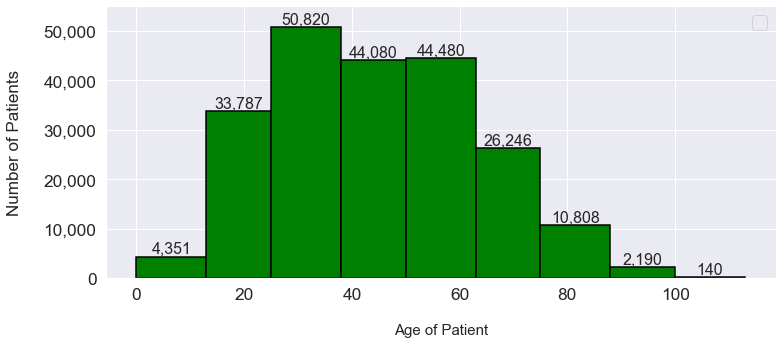

In [288]:
%matplotlib inline
sns.set()

# plot age distribution
ax = patient_df['patient_age']\
        .hist(bins=age_bins, color='green', edgecolor='black', linewidth=1.5,figsize=(12,5))

ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Number of Patients\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=16)

## add extra room at top of figure
ax.set_ylim(0, 55000)

plt.legend(loc='upper right', prop={'size': 18})
# plt.savefig("figures/patient-age-distribution.png", dpi=600, bbox_inches="tight")
plt.show()

### plot female/male age distribution

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/2038010311.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


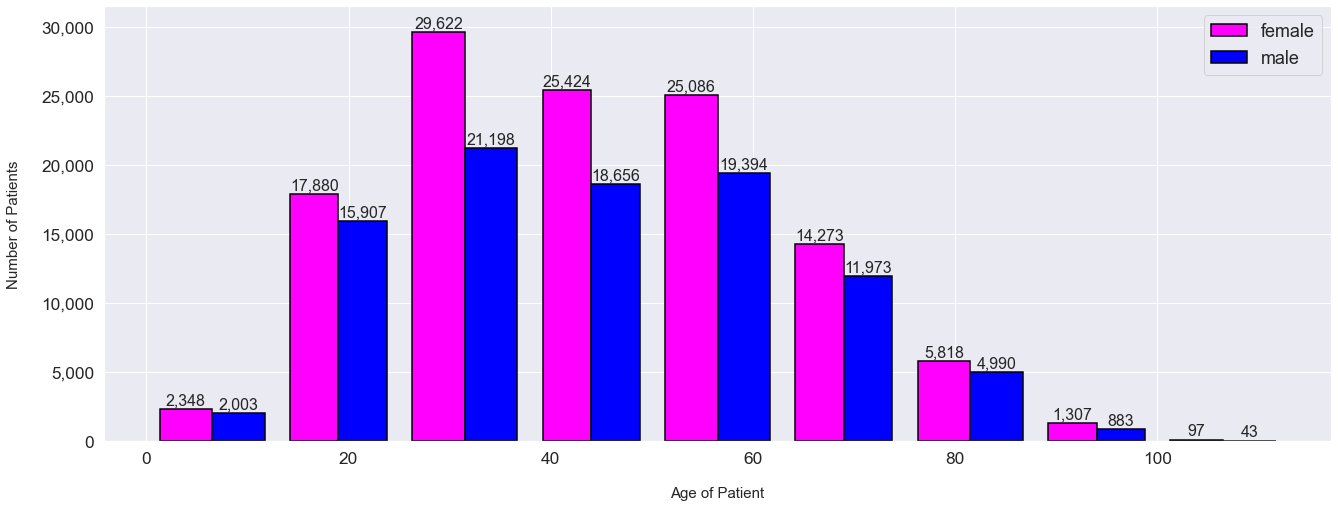

In [289]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue']
sns.set_palette(colors)

# create separate series for genders
females = patient_df.query("gender == 'female'")['patient_age']
males = patient_df.query("gender == 'male'")['patient_age']

fig, ax = plt.subplots(figsize=(22,8)) 
ax.hist([females, males], bins=age_bins, edgecolor='black', linewidth=1.5, label=['female', 'male'])
ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Number of Patients\n", fontsize=15)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=16)

## add extra room at top of figure
ax.set_ylim(0, 31500)

# plt.figure(figsize=(12,7))
plt.legend(loc='upper right', prop={'size': 18})
# plt.savefig("figures/patient-age-gender-distribution.png", dpi=600, bbox_inches="tight")
plt.show()

In [280]:
age_table

,age_range,total,female_total,male_total,percent_female,percent_male
0,"[0.0, 13.0)",4351,2348,2003,54.0,46.0
1,"[13.0, 25.0)",33787,17880,15907,52.9,47.1
2,"[25.0, 38.0)",50820,29622,21198,58.3,41.7
3,"[38.0, 50.0)",44080,25424,18656,57.7,42.3
4,"[50.0, 63.0)",44480,25086,19394,56.4,43.6
5,"[63.0, 75.0)",26246,14273,11973,54.4,45.6
6,"[75.0, 88.0)",10808,5818,4990,53.8,46.2
7,"[88.0, 100.0)",2190,1307,883,59.7,40.3
8,"[100.0, 113.0)",140,97,43,69.3,30.7


## summarize the number of patients (that had a procedure) over time

### merge patient info with procedure date info

In [259]:
patient_proc_date_df = \
    pds.merge(patient_df, tooth_proc_df[['patient_id', 'event_date']], how='inner', on='patient_id').drop_duplicates()

In [260]:
# patient_proc_date_df.head()

### add year of procedure

In [290]:
patient_proc_date_df.event_date = pds.to_datetime(patient_proc_date_df.event_date) # convert to datetime
patient_proc_date_df['event_year'] = pds.DatetimeIndex(patient_proc_date_df.event_date).year # get just the year
patient_proc_date_df.drop_duplicates(inplace=True) # remove any duplicates

In [291]:
# patient_proc_date_df.head()

### drop any year beyond 2015

In [292]:
patient_proc_date_df = patient_proc_date_df[patient_proc_date_df.event_year < 2016]

### calculate yearly totals

In [293]:
patient_proc_date_count_df = \
    pds.DataFrame(patient_proc_date_df.groupby('event_year')['event_year'].count()).rename(columns={'event_year': 'total'}).reset_index()

In [294]:
patient_proc_date_count_df[(patient_proc_date_count_df.event_year > 1998) & (patient_proc_date_count_df.event_year < 2016)]

,event_year,total
20,1999,13244
21,2000,18664
22,2001,25313
23,2002,32945
24,2003,43502
25,2004,48940
26,2005,52295
27,2006,51952
28,2007,54776
29,2008,58316


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/822682154.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


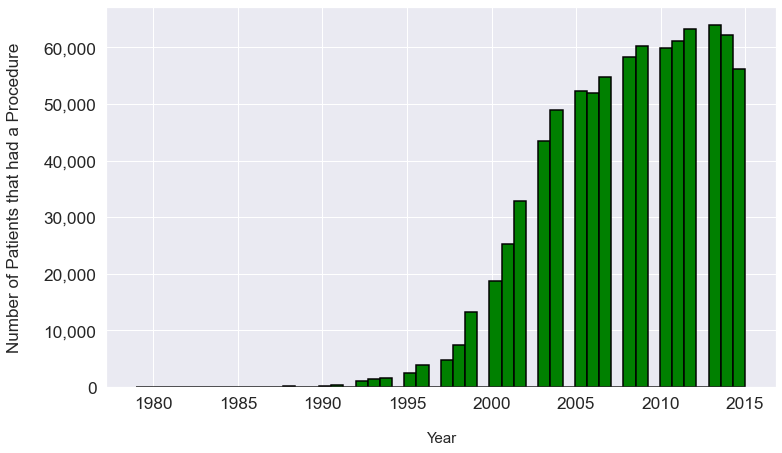

In [295]:
%matplotlib inline
sns.set()

# plot age distribution
ax = patient_proc_date_df['event_year']\
        .hist(bins=50, color='green', edgecolor='black', linewidth=1.5,figsize=(12,7))

ax.set_xlabel("\nYear", fontsize=15)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.savefig("figures/patient-count-by-year-hist.png", dpi=600, bbox_inches="tight")
plt.show()

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/30735053.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


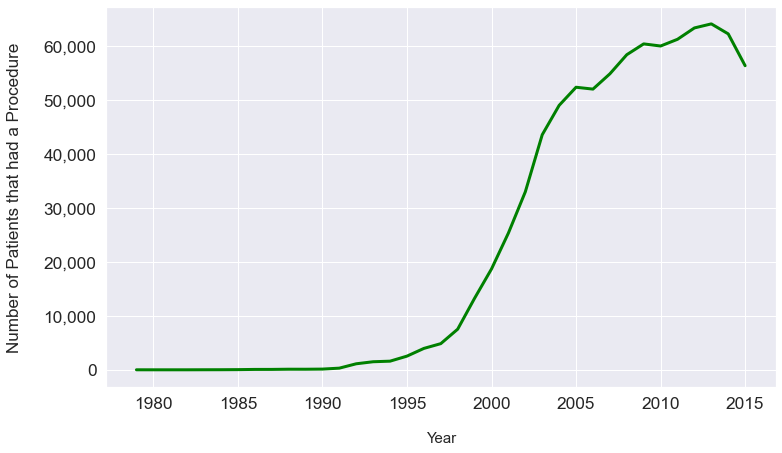

In [296]:
%matplotlib inline
sns.set()
sns.set_context(rc={"lines.linewidth": 3})

plt.figure(figsize=(12,7))
ax = sns.lineplot(x="event_year", y="total", data=patient_proc_date_count_df, color="green")

ax.set_xlabel("\nYear", fontsize=15)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("figures/patient-count-by-year-line.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize the number of patients (that had a procedure) over time by gender

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/1759076017.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


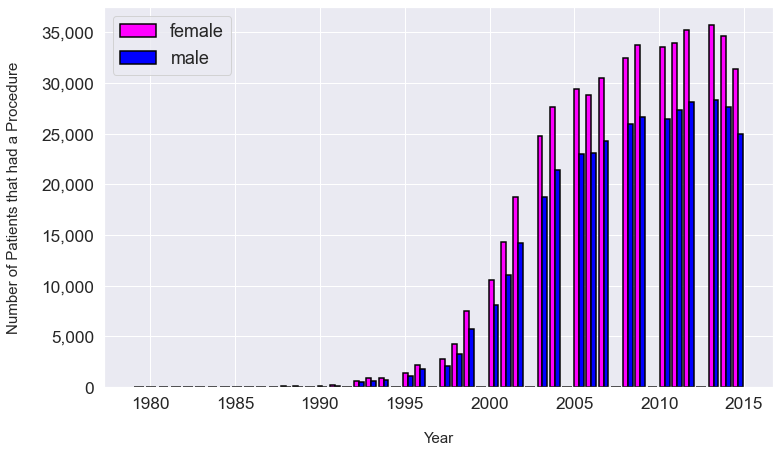

In [297]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue']
sns.set_palette(colors)

# create separate series for genders
females_year = patient_proc_date_df.query("gender == 'female'")['event_year']
males_year = patient_proc_date_df.query("gender == 'male'")['event_year']

fig, ax = plt.subplots(figsize=(12,7)) 
ax.hist([females_year, males_year], bins=50, edgecolor='black', linewidth=1.5, label=['female', 'male'])
ax.set_xlabel("\nYear", fontsize=15)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=15)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper left', prop={'size': 18})
plt.savefig("figures/patient-count-by-year-and-gender-bar.png", dpi=600, bbox_inches="tight")
plt.show()

In [298]:
patient_gender_proc_date_count_df = \
    pds.DataFrame(patient_proc_date_df.groupby(['event_year', 'gender'])['event_year'].count()).rename(columns={'event_year': 'total'}).reset_index()
patient_gender_proc_date_count_df.sort_values(by='gender', inplace=True)

In [299]:
# patient_gender_proc_date_count_df

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_28002/4186733128.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


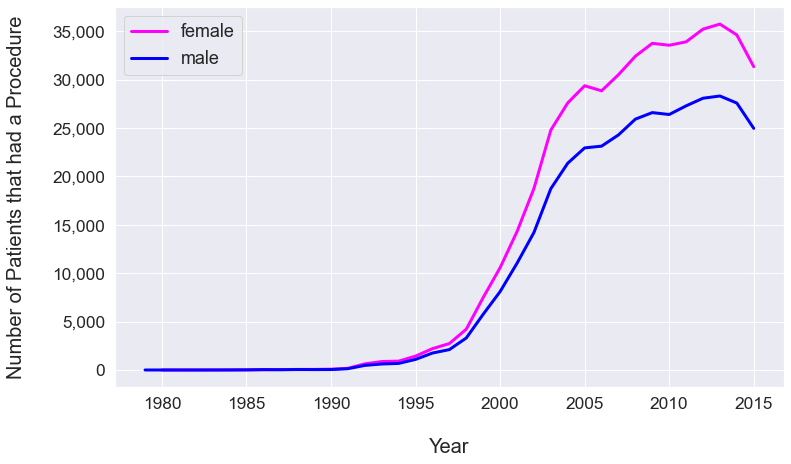

In [300]:
%matplotlib inline
sns.set()
sns.set_context(rc={"lines.linewidth": 3})
colors = ['magenta', 'blue']
sns.set_palette(colors)

plt.figure(figsize=(12,7))
ax = sns.lineplot(x="event_year", y="total", data=patient_gender_proc_date_count_df, hue="gender", legend=False)

ax.set_xlabel("\nYear", fontsize=20)
ax.set_ylabel("Number of Patients that had a Procedure\n", fontsize=20)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper left', labels=['female', 'male'], prop={'size': 18})
plt.savefig("figures/patient-count-by-year-and-gender-line.png", dpi=600, bbox_inches="tight")
plt.show()